https://learnopencv.com/contour-detection-using-opencv-python-c/

This is for the opencv implementation. Does not work for our dataset.

https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [1]:
import tensorflow
import tensorflow.keras

# loading and processing images
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
# models
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

# clustering and dimentsion reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import _pca # dim reducer

# for everything elese
import os 
import numpy as np
import matplotlib.pyplot as plt 
from random import randint
import pandas as pd
import pickle
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from PIL import Image

Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16868135739942419332
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9853468672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10243678109859440022
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [3]:
path = r"./steel_images"
# change the working directory to the path where the images are located
# os.chdir(path)

# this list holds all the image filename
steels = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
            
          # adds only the image files to the steels list
            steels.append(file.name)

In [4]:
model = VGG19()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [6]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = Image.open(file)
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx)
    return features

In [7]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx)
    return features

In [8]:
img = load_img(os.path.join(path, "0b56da4ff.jpg"), target_size=(224,896))
img.show()
features = extract_features(os.path.join(path, "0b56da4ff.jpg"), model)
features

1/1 [==============================] - 64s 64s/step


array([[0.        , 0.15505934, 0.        , ..., 0.        , 0.8556296 ,
        0.43356225]], dtype=float32)

In [9]:
data = {}
p = r"./modelDev/features.txt"

# loop through each image in the dataset
for steel in steels:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(os.path.join(path, steel), model)
        data[steel] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

1/1 [==============================] - 0s 28ms/step


In [10]:
len(data)

12568

In [11]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

unique_labels = np.unique(feat)

In [12]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [13]:
# cluster feature vectors
kmeans = KMeans(n_clusters=4, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=4, random_state=22)

In [14]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

Given below is the number of photos given for each cluster where k = 4. Group 3 has substantially less photos than the other groups. 

In [15]:
for i in range(0, len(groups)):
    mystr = 'group ' + str(i + 1) + ' , length: ' + str(len(groups[i]))
    print(mystr)

group 1 , length: 6282
group 2 , length: 2958
group 3 , length: 408
group 4 , length: 2920


In [16]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [17]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

Text(0, 0.5, 'Sum of squared distance')

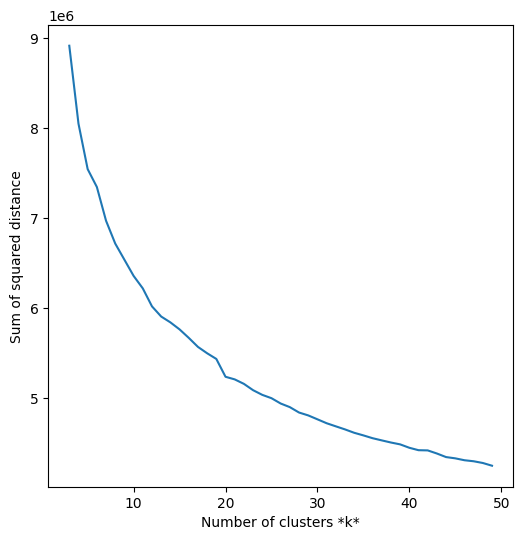

In [18]:
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [19]:
import shutil

newPath = './clustLabel'

for i in range(0, len(groups)): # ith cluster
    try:
        labelPath = os.path.join(newPath, 'group', str(i+1))
        if not os.path.exists(labelPath):
            os.makedirs(labelPath)
            print(labelPath, " directory created!!")
        for j in range(0, len(groups[i])): # jth image in the ith cluster
            shutil.copy(os.path.join(path, groups[i][j]), os.path.join(labelPath, groups[i][j]))
            # shutil.copy(path + groups[i][j], labelPath + groups[i][j])
    except Exception as e:
        print(e)
        

./clustLabel\group\1  directory created!!
./clustLabel\group\2  directory created!!
./clustLabel\group\3  directory created!!
./clustLabel\group\4  directory created!!


In [20]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_files):
    fig = figure()
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        figure(figsize=(5, 3), dpi=80)
        # a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        # figure(figsize=(8, 6), dpi=80)
        axis('off')

In [37]:
# from PIL import Image

# def showImages(sampleSize, path, fileGroup):
#     try:
#         myFiles = []
#         count = 0
#         with os.scandir(path + fileGroup) as files:
#             for file in files:
#                 if count == sampleSize:
#                     break
#                 myFiles.append(path + fileGroup + file.name)
#         showImagesHorizontally(myFiles)
#     except Exception as e:
#         print(e)

In [21]:
from PIL import Image

def getImages(sampleSize, path):
    try:
        myFiles = []
        count = 0
        for i in range(0, len(groups)):
            groupFiles = []
            for j in range(0, sampleSize):
                tmpPathName = os.path.join(path, 'group', str(i+1), groups[i][j])
                groupFiles.append(tmpPathName)
                # groupFiles.append(path + 'group' + str(i+1) + '/' + groups[i][j])
            myFiles.append(groupFiles)
        return myFiles
        

    except Exception as e:
        print(e)

In [22]:
clustImages = getImages(10, newPath)

<Figure size 640x480 with 0 Axes>

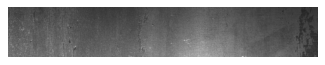

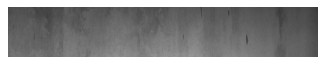

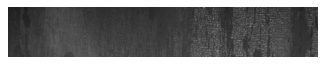

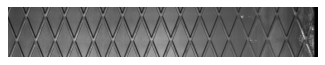

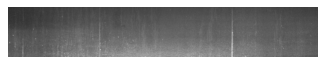

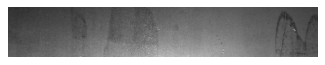

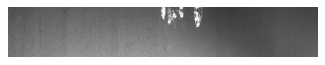

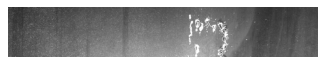

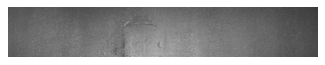

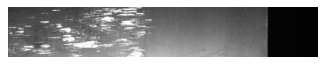

In [23]:
showImagesHorizontally(clustImages[0])

<Figure size 640x480 with 0 Axes>

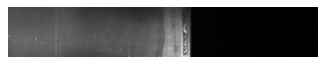

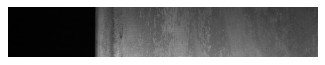

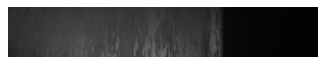

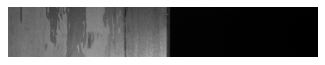

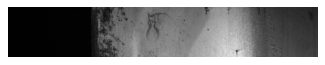

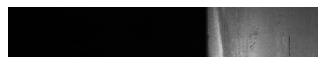

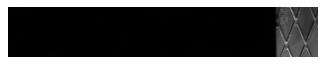

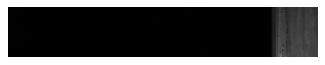

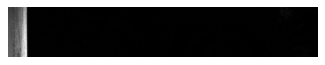

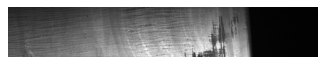

In [24]:
showImagesHorizontally(clustImages[1])

<Figure size 640x480 with 0 Axes>

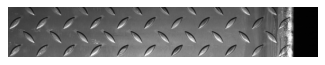

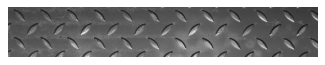

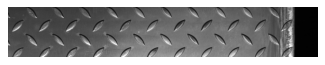

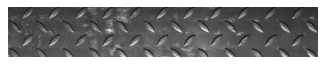

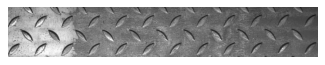

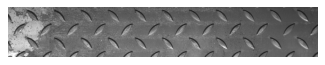

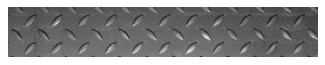

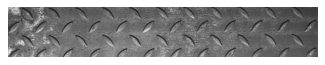

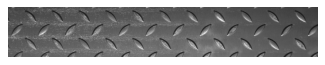

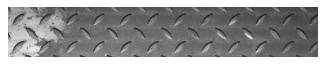

In [25]:
showImagesHorizontally(clustImages[2])

<Figure size 640x480 with 0 Axes>

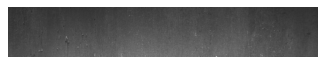

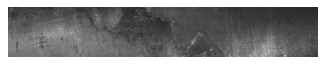

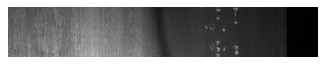

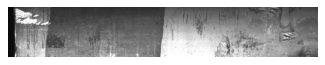

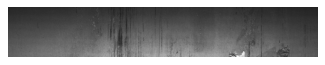

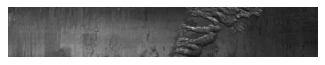

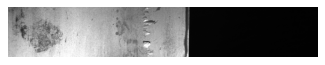

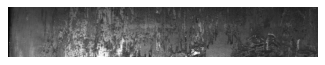

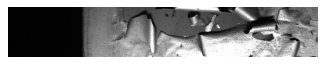

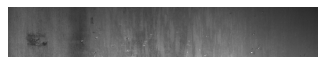

In [26]:
showImagesHorizontally(clustImages[3])

<h1>Issues</h1>
<p>We have large black regions in the first group and this could potentially skewing our generated features</p>
<p>We will try to get rid of these regions and then use k-means clustering again. </p>

In [ ]:
data = {}
p = r"./modelDev2/features.txt"

# loop through each image in the dataset
for steel in steels:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(os.path.join(path, steel), model)
        data[steel] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

In [ ]:
len(data)

In [ ]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

unique_labels = np.unique(feat)